# Agenda
1. Text Classification using TensorFlow with PreTrained Embedding Layer
   - Import essential modules
   - Import IMDB datasets
   - Explore datsets
   - Build Models
   - Training 
   - Evaluate
   
2. Text Classification with training of Embedding Layer
   - Import IMDB datasets
   - Exploring data
   - Preprocessing - Padding
   - Build Models
   - Training
   - Evaluate
   
<hr>

#### Import Modules
* Install tensorflow_hub & tensorflow_datasets using -- 'pip install tensorflow-hub,tensorflow-datsets'
* TensorFlowHub contains many pretrained model
* TensorFlowDatasets contains many datsets used for learning purpose

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#### Import Datasets

In [4]:
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(name="imdb_reviews", split=(train_validation_split, tfds.Split.TEST), as_supervised=True)

W0724 16:28:52.531581 140047572678464 deprecation.py:323] From /home/awantik/anaconda3/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/awantik/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


#### Explore datasets

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(2)))
train_examples_batch

<tf.Tensor: id=232, shape=(2,), dtype=string, numpy=
array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story pe

In [7]:
train_labels_batch

<tf.Tensor: id=233, shape=(2,), dtype=int64, numpy=array([1, 1])>

#### Build Model
* Input data is text & output data is 0/1 label
* Three main architectural decisions
  - Text Representation
  - Layers in the model
  - Hidden units in each layer
  
* Text can be converted into embedding vectors
* We can use pretrained embedding as first layer
  - we don't have to worry about text preprocessing, 
  - we can benefit from transfer learning, 
  - the embedding has a fixed size, so it's simpler to process.
  
 * https://www.tensorflow.org/hub

In [8]:
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

In [11]:
embeddings.shape

TensorShape([2, 20])

In [12]:
embeddings[0]

<tf.Tensor: id=416, shape=(20,), dtype=float32, numpy=
array([ 0.8666395 ,  0.35917717,  0.00579667,  0.681002  , -0.54226625,
        0.22343187, -0.38796625,  0.62195706,  0.22117122, -0.48538068,
       -1.2674141 ,  0.886369  , -0.3284907 , -0.13924702, -0.53327686,
        0.5739708 , -0.05905761,  0.13629246, -1.1718255 , -0.31494334],
      dtype=float32)>

* Can be added to Keras layer as well

In [13]:
hub_layer = hub.KerasLayer(embed, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: id=422, shape=(2, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ]],
      dtype=float32)>

In [18]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


* Vocabulary contains 20,000 tokens and 1 out of vocabulary bucket for unknown tokens.
* Params == 20,000 * 20 + 20 (bias)

#### Loss & Optimizer
* 'binary_crossentropy' because this is a binary classification problem.

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train Model
* Train the model for 20 epochs in mini-batches of 512 samples. 
* This is 20 iterations over all samples in the x_train and y_train tensors. 
* While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set

In [20]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20


W0724 17:22:56.798352 140047572678464 deprecation.py:323] From /home/awantik/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


30/30 [==============================] - 4s 127ms/step - loss: 0.7373 - accuracy: 0.5433 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 2s 80ms/step - loss: 0.6645 - accuracy: 0.6000 - val_loss: 0.6494 - val_accuracy: 0.6221
Epoch 3/20
30/30 [==============================] - 2s 78ms/step - loss: 0.6446 - accuracy: 0.6314 - val_loss: 0.6340 - val_accuracy: 0.6471
Epoch 4/20
30/30 [==============================] - 2s 82ms/step - loss: 0.6326 - accuracy: 0.6445 - val_loss: 0.6242 - val_accuracy: 0.6557
Epoch 5/20
30/30 [==============================] - 2s 81ms/step - loss: 0.6229 - accuracy: 0.6543 - val_loss: 0.6159 - val_accuracy: 0.6604
Epoch 6/20
30/30 [==============================] - 3s 86ms/step - loss: 0.6146 - accuracy: 0.6640 - val_loss: 0.6089 - val_accuracy: 0.6660
Epoch 7/20
30/30 [==============================] - 2s 81ms/step - loss: 0.6079 - accuracy: 0.6690 - val_loss: 0.6030 - val_accuracy: 0.6720
Epoch 8/20
30/3

#### Evaluate the Model

In [21]:
results = model.evaluate(test_data.batch(512), verbose=0)
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

loss: 0.573
accuracy: 0.701


In [29]:
model.predict_classes([['Bad Not Great stuff']])

array([[1]], dtype=int32)

#### Import Dataset

In [31]:
imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [33]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


* get_word_index() returns mapping of word & id

In [36]:
word_dict = imdb.get_word_index()

In [38]:
word_dict['fawn']

34701

* Converting number to text so that we can explore the data

In [47]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_dict.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [48]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

#### Preprocessing
* Add padding to the number sequence of text
* Limit the text size to fixed 256 of more than 256

In [50]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [51]:
train_data.shape

(25000, 256)

#### Build Model
* The first layer is an Embedding layer. 
* This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. 
* These vectors are learned as the model trains. 
* The vectors add a dimension to the output array. 
* The resulting dimensions are: (batch, sequence, embedding).
* GlobalAveragePooling1D is an average pooling layer. It also convert output from 2D to 1D
* Then, we have fully connected Dense layer
* Sigmoid in last layer as value is between 0 & 1

In [52]:
vocab_size = 10000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 16))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### Loss Function & Optimizer

In [53]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

#### Create a validation set

In [54]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### Model Training

In [55]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 139us/sample - loss: 0.6918 - acc: 0.5046 - val_loss: 0.6894 - val_acc: 0.5317
Epoch 2/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6860 - acc: 0.5667 - val_loss: 0.6815 - val_acc: 0.6309
Epoch 3/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6743 - acc: 0.6364 - val_loss: 0.6667 - val_acc: 0.6650
Epoch 4/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6528 - acc: 0.7126 - val_loss: 0.6412 - val_acc: 0.7113
Epoch 5/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6207 - acc: 0.7577 - val_loss: 0.6071 - val_acc: 0.7644
Epoch 6/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.5794 - acc: 0.8003 - val_loss: 0.5667 - val_acc: 0.8076
Epoch 7/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.5332 - acc: 0.8313 - val_loss: 0

#### Evaluate the model

In [56]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 27us/sample - loss: 0.3340 - acc: 0.8721
[0.3339851458263397, 0.87212]


In [58]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

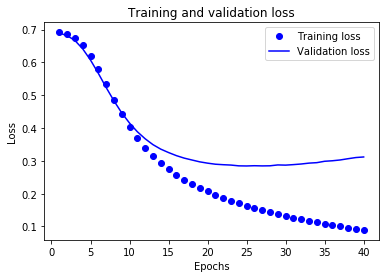

In [61]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

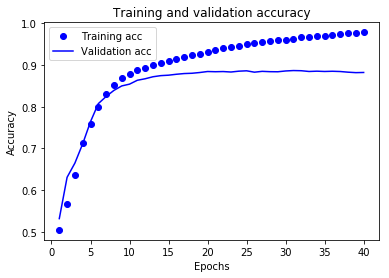

In [62]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()